In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pynlo

In [20]:
FWHM = 0.180  # pulse duration (ps)
pulseWL = 1030  # pulse central wavelength (nm)
EPP = 50e-12  # Energy per pulse (J)
GDD = 0.0  # Group delay dispersion (ps^2)
TOD = 0.0  # Third order dispersion (ps^3)

Window = 10.0  # simulation window (ps)
Steps = 100  # simulation steps
Points = 2**13  # simulation points

beta2 = -120  # (ps^2/km)
beta3 = 0.00  # (ps^3/km)
beta4 = 0.005  # (ps^4/km)

Length = 50  # length in mm

Alpha = 0.0  # attentuation coefficient (dB/cm)
Gamma = 1000  # Gamma (1/(W km)

fibWL = pulseWL  # Center WL of fiber (nm)

Raman = True  # Enable Raman effect?
Steep = True  # Enable self steepening?

alpha = np.log((10 ** (Alpha * 0.1))) * 100  # convert from dB/cm to 1/m

In [21]:
######## This is where the PyNLO magic happens! ############################

# create the pulse!
pulse = pynlo.light.DerivedPulses.SechPulse(
    power=1,  # Power will be scaled by set_epp
    T0_ps=FWHM / 1.76,
    center_wavelength_nm=pulseWL,
    time_window_ps=Window,
    GDD=GDD,
    TOD=TOD,
    NPTS=Points,
    frep_MHz=1,
    power_is_avg=False,
)
# set the pulse energy!
pulse.set_epp(EPP)

# create the fiber!
fiber1 = pynlo.media.fibers.fiber.FiberInstance()
fiber1.generate_fiber(
    Length * 1e-3,
    center_wl_nm=fibWL,
    betas=(beta2, beta3, beta4),
    gamma_W_m=Gamma * 1e-3,
    gvd_units="ps^n/km",
    gain=-alpha,
)

# Propagation
evol = pynlo.interactions.FourWaveMixing.SSFM.SSFM(
    local_error=0.005,
    USE_SIMPLE_RAMAN=True,
    disable_Raman=np.logical_not(Raman),
    disable_self_steepening=np.logical_not(Steep),
)

y, AW, AT, pulse_out = evol.propagate(pulse_in=pulse, fiber=fiber1, n_steps=Steps)

########## That's it! Physics complete. Just plotting commands from here! ################

Pulse energy before Simple Fiber : 0.05000000000000002 nJ
pulse energy in  0.004115188557268177
copied as   0.004115188557268177
Step: 0 Distance remaining: 0.05
Pulse energy after: 4.970118543944578e-08 mJ
Step: 1 Distance remaining: 0.0495
Pulse energy after: 4.970034418031881e-08 mJ
Step: 2 Distance remaining: 0.049
Pulse energy after: 4.9699095326023525e-08 mJ
Step: 3 Distance remaining: 0.0485
Pulse energy after: 4.96974251333431e-08 mJ
Step: 4 Distance remaining: 0.048
Pulse energy after: 4.969531377880273e-08 mJ
Step: 5 Distance remaining: 0.0475
Pulse energy after: 4.969273477275496e-08 mJ
Step: 6 Distance remaining: 0.047
Pulse energy after: 4.9689654155774957e-08 mJ
Step: 7 Distance remaining: 0.0465
Pulse energy after: 4.9686029447996856e-08 mJ
Step: 8 Distance remaining: 0.046000000000000006
Pulse energy after: 4.9681808312983173e-08 mJ
Step: 9 Distance remaining: 0.045500000000000006
Pulse energy after: 4.9676926891029246e-08 mJ
Step: 10 Distance remaining: 0.0450000000000

C:\Users\Jeremy\AppData\Local\Temp/ipykernel_13932/4103883923.py:11: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(np.abs(num)**2)


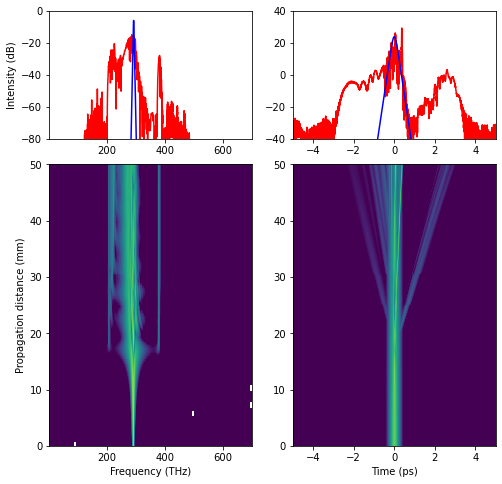

In [23]:
# set up plots for the results:
fig = plt.figure(figsize=(8, 8))
ax0 = plt.subplot2grid((3, 2), (0, 0), rowspan=1)
ax1 = plt.subplot2grid((3, 2), (0, 1), rowspan=1)
ax2 = plt.subplot2grid((3, 2), (1, 0), rowspan=2, sharex=ax0)
ax3 = plt.subplot2grid((3, 2), (1, 1), rowspan=2, sharex=ax1)

F = pulse.F_THz  # Frequency grid of pulse (THz)


def dB(num):
    return 10 * np.log10(np.abs(num) ** 2)


zW = dB(np.transpose(AW)[:, (F > 0)])
zT = dB(np.transpose(AT))

y_mm = y * 1e3  # convert distance to mm

ax0.plot(pulse_out.F_THz, dB(pulse_out.AW), color="r")
ax1.plot(pulse_out.T_ps, dB(pulse_out.AT), color="r")

ax0.plot(pulse.F_THz, dB(pulse.AW), color="b")
ax1.plot(pulse.T_ps, dB(pulse.AT), color="b")

extent = (np.min(F[F > 0]), np.max(F[F > 0]), 0, Length)
ax2.imshow(
    zW,
    extent=extent,
    vmin=np.max(zW) - 40.0,
    vmax=np.max(zW),
    aspect="auto",
    origin="lower",
)

extent = (np.min(pulse.T_ps), np.max(pulse.T_ps), np.min(y_mm), Length)
ax3.imshow(
    zT,
    extent=extent,
    vmin=np.max(zT) - 40.0,
    vmax=np.max(zT),
    aspect="auto",
    origin="lower",
)


ax0.set_ylabel("Intensity (dB)")
ax0.set_ylim(-80, 0)
ax1.set_ylim(-40, 40)

ax2.set_ylabel("Propagation distance (mm)")
ax2.set_xlabel("Frequency (THz)")
# ax2.set_xlim(0,400)

ax3.set_xlabel("Time (ps)")

plt.show()